<div style="
  background-color: #e3f2fd;
  padding: 15px;
  border-left: 6px solid #0d47a1;
  border-radius: 8px;
  font-family: 'Georgia', serif;
  color: #01579b;
  font-size: 28px;
  text-align: center;
  font-weight: bold;
">
  📚 Import Libraries
</div>


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm
import cv2
import os
import seaborn as sns
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Conv2D, Reshape, Input, Conv2DTranspose
from keras.layers import Activation, LeakyReLU, BatchNormalization, Dropout, Resizing
from tensorflow.keras import layers
from keras.losses import BinaryCrossentropy
from tensorflow.keras.applications import VGG16
import random
import glob
import albumentations as A
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import warnings
warnings.filterwarnings('ignore')


/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.18 (you have 1.4.17). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.

  check_for_updates()


<div style="
  background-color: #e3f2fd;
  padding: 15px;
  border-left: 6px solid #0d47a1;
  border-radius: 8px;
  font-family: 'Georgia', serif;
  color: #01579b;
  font-size: 28px;
  text-align: center;
  font-weight: bold;
">
  📌 Constants
</div>


In [2]:
# Directories for the PNEUMONIA class images
train_pneumonia_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA'
test_pneumonia_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA'
valid_pneumonia_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/val/PNEUMONIA'

target_size = (128, 128)
batch_size = 32


<div style="
  background-color: #e3f2fd;
  padding: 15px;
  border-left: 6px solid #0d47a1;
  border-radius: 8px;
  font-family: 'Georgia', serif;
  color: #01579b;
  font-size: 28px;
  text-align: center;
  font-weight: bold;
">
  ⚙️ Functions
</div>


In [3]:
def plot_multiple_img(img_matrix_list, title_list, ncols, main_title=""):
    fig, myaxes = plt.subplots(figsize=(20, 15), nrows=3, ncols=ncols, squeeze=False)
    fig.suptitle(main_title, fontsize = 30)
    fig.subplots_adjust(wspace=0.3)
    fig.subplots_adjust(hspace=0.3)
    for i, (img, title) in enumerate(zip(img_matrix_list, title_list)):
        myaxes[i // ncols][i % ncols].imshow(img)
        myaxes[i // ncols][i % ncols].set_title(title, fontsize=15)
    plt.show()

In [4]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)
        if img is not None:
            image_resized = cv2.resize(img, target_size)
            images.append(image_resized)
    return images

<div style="
  background-color: #e3f2fd;
  padding: 15px;
  border-left: 6px solid #0d47a1;
  border-radius: 8px;
  font-family: 'Georgia', serif;
  color: #01579b;
  font-size: 28px;
  text-align: center;
  font-weight: bold;
">
  🔍 Exploring The Data

</div>


In [3]:
# Look at the training, testing and validation data numbers
train_data = glob.glob('../input/chest-xray-pneumonia/chest_xray/train/**/*.jpeg')
test_data = glob.glob('../input/chest-xray-pneumonia/chest_xray/test/**/*.jpeg')
val_data = glob.glob('../input/chest-xray-pneumonia/chest_xray/val/**/*.jpeg')

print(f"Training Set has: {len(train_data)} images")
print(f"Testing Set has: {len(test_data)} images")
print(f"Validation Set has: {len(val_data)} images")

Training Set has: 5216 images

Testing Set has: 624 images

Validation Set has: 16 images


In [4]:
DIR = "../input/chest-xray-pneumonia/chest_xray/"
sets = ["train", "test", "val"]
all_pneumonia = []
all_normal = []

for cat in sets:
    path = os.path.join(DIR, cat)
    norm = glob.glob(os.path.join(path, "NORMAL/*.jpeg"))
    pneu = glob.glob(os.path.join(path, "PNEUMONIA/*.jpeg"))
    all_normal.extend(norm)
    all_pneumonia.extend(pneu)

print(f"Total Pneumonia Images: {len(all_pneumonia)}")
print(f"Total Normal Images: {len(all_normal)}")

Total Pneumonia Images: 4273

Total Normal Images: 1583


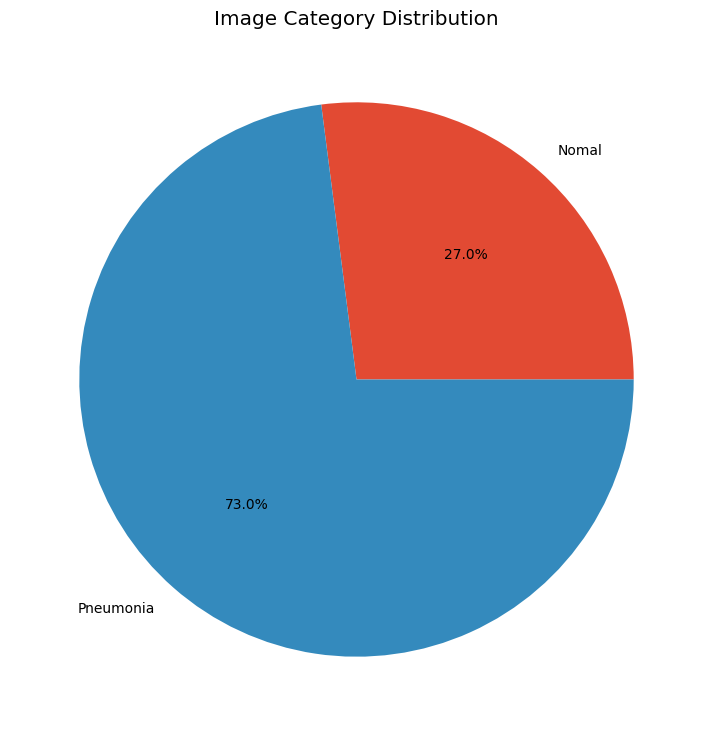

In [5]:
labels = ['Nomal', 'Pneumonia']
targets = [len(all_normal), len(all_pneumonia)]

plt.style.use("ggplot")
plt.figure(figsize=(16, 9))
plt.pie(x=targets, labels=labels, autopct="%1.1f%%")
plt.title("Image Category Distribution")
plt.show()

* We can see that there's some good data imbalance, we have more data for Pneumonia Images then for the Normal Images.

In [6]:
# Shuffle and Get some images into new list
random.shuffle(all_normal)
random.shuffle(all_pneumonia)
images = all_normal[:50] + all_pneumonia[:50]

## Basic X-Ray Images


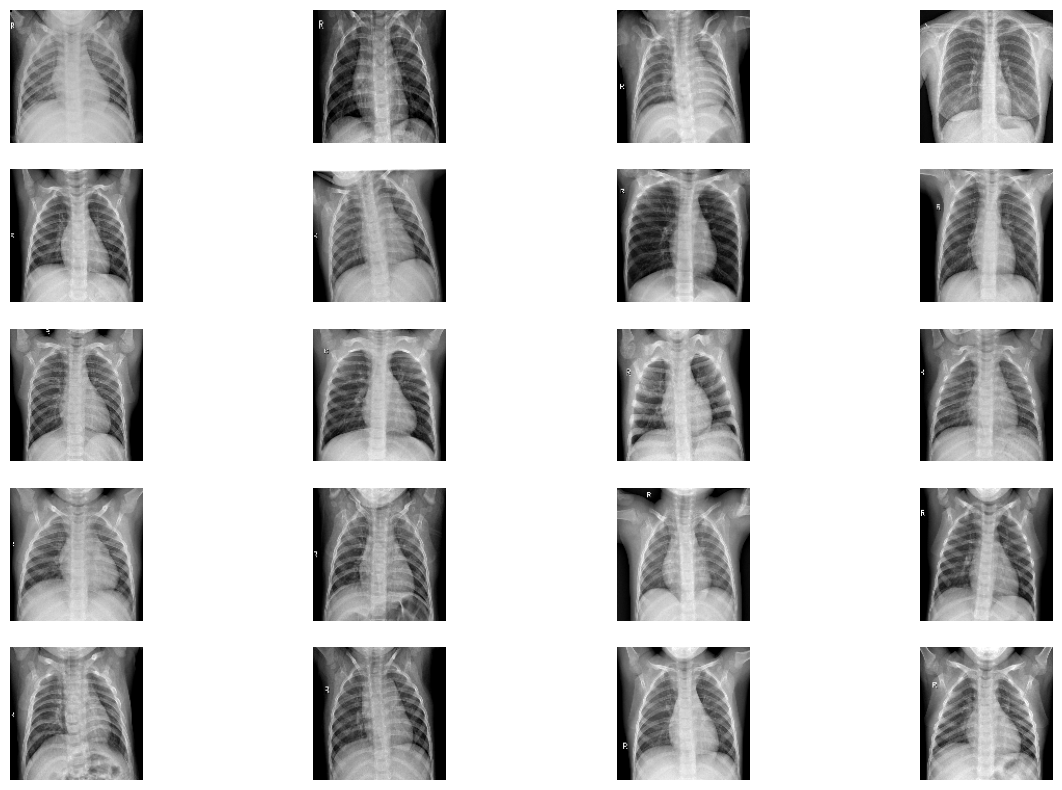

In [7]:
fig=plt.figure(figsize=(15, 10))
columns = 4; rows = 5
for i in range(1, columns*rows +1):
    img = cv2.imread(images[i])
    img = cv2.resize(img, (128, 128))
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.axis(False)

## Ben Graham's Method


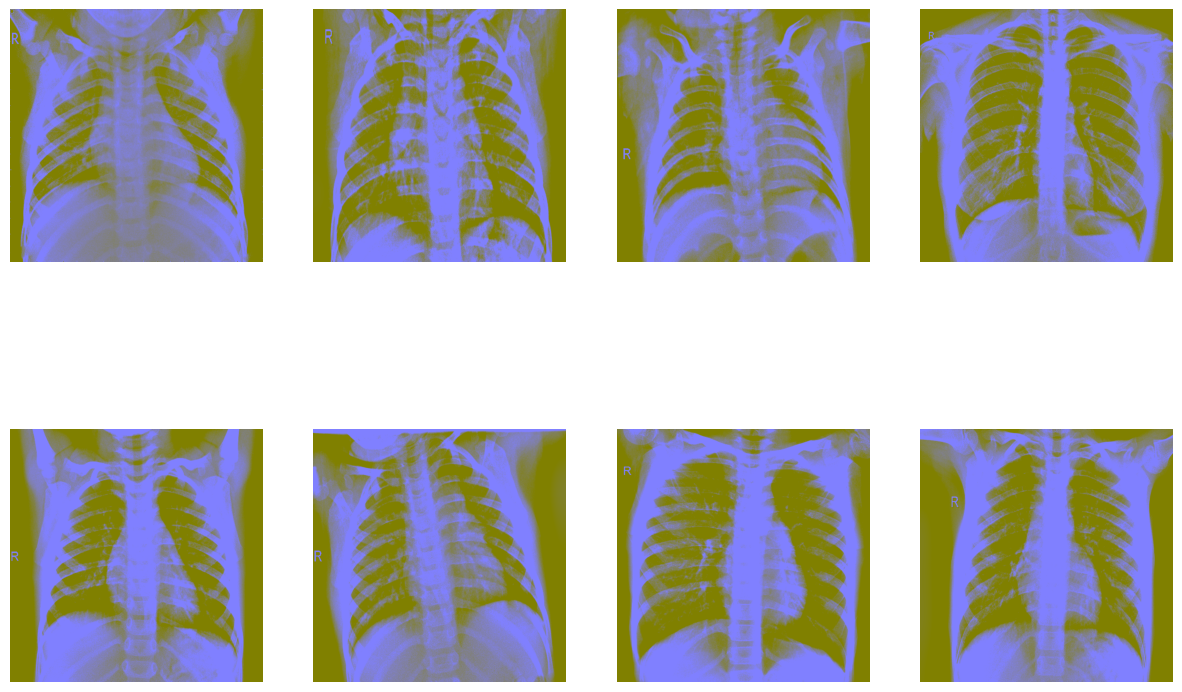

In [8]:
fig=plt.figure(figsize=(15, 10))
columns = 4; rows = 2
for i in range(1, columns*rows +1):
    img = cv2.imread(images[i])
    img = cv2.resize(img, (512, 512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    img = cv2.addWeighted (img, 4, cv2.GaussianBlur(img, (0,0), 512/10), -4, 128)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.axis(False)


## Fourier Method for Pixel Distribution

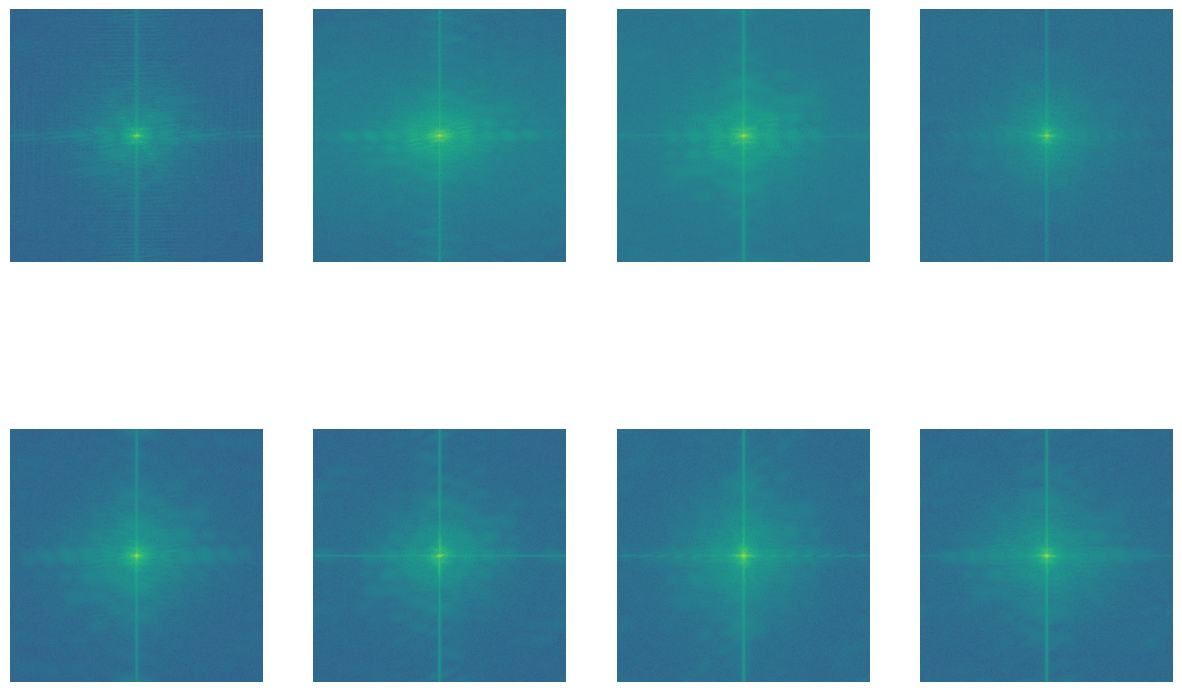

In [9]:
fig=plt.figure(figsize=(15, 10))
columns = 4; rows = 2
for i in range(1, columns*rows +1):
    img = cv2.imread(images[i])
    img = cv2.resize(img, (512, 512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)
    magnitude_spectrum = 20*np.log(np.abs(fshift))
    fig.add_subplot(rows, columns, i)
    plt.imshow(magnitude_spectrum)
    plt.axis(False)

* Those images are basically magnitude spectrums, this helps in understanding where majority of growth is situated.

## Albumentations Visualization

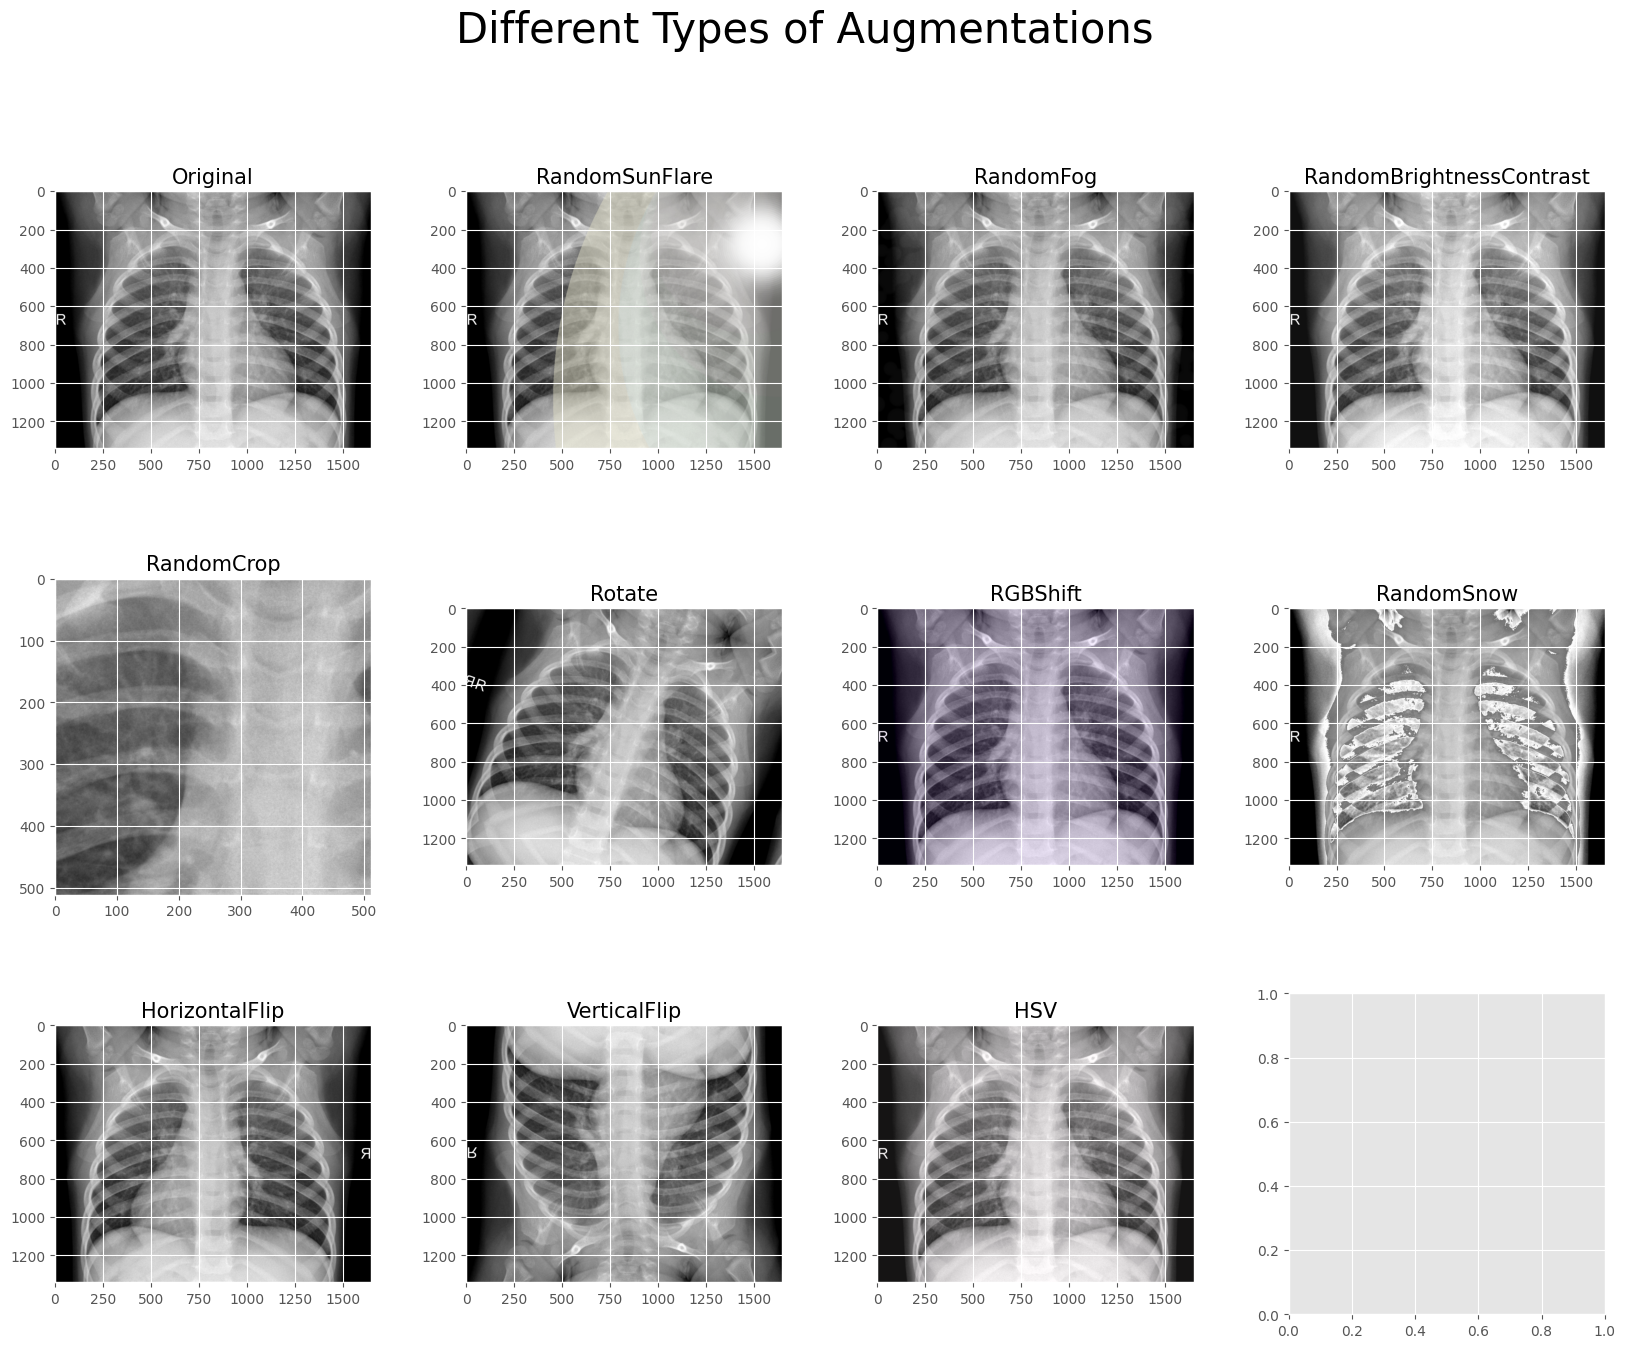

In [10]:
chosen_image = cv2.imread(images[25])

albumentation_list = [
    A.RandomSunFlare(p=1), 
    A.RandomFog(p=1), 
    A.RandomBrightnessContrast(p=1),  # Corrected
    A.RandomCrop(p=1, height=512, width=512), 
    A.Rotate(p=1, limit=90),
    A.RGBShift(p=1), 
    A.RandomSnow(p=1),
    A.HorizontalFlip(p=1), 
    A.VerticalFlip(p=1), 
    A.HueSaturationValue(p=1, hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=50)
]

img_matrix_list = []
bboxes_list = []
for aug_type in albumentation_list:
    img = aug_type(image=chosen_image)['image']
    img_matrix_list.append(img)

# Include the original image at the start of the list
img_matrix_list.insert(0, chosen_image)

# Updated titles list
titles_list = [
    "Original", "RandomSunFlare", "RandomFog", "RandomBrightnessContrast", 
    "RandomCrop", "Rotate", "RGBShift", "RandomSnow", 
    "HorizontalFlip", "VerticalFlip", "HSV"
]

# Assuming plot_multiple_img is a function to display multiple images
plot_multiple_img(img_matrix_list, titles_list, ncols=4, main_title="Different Types of Augmentations")


## Image Erosion

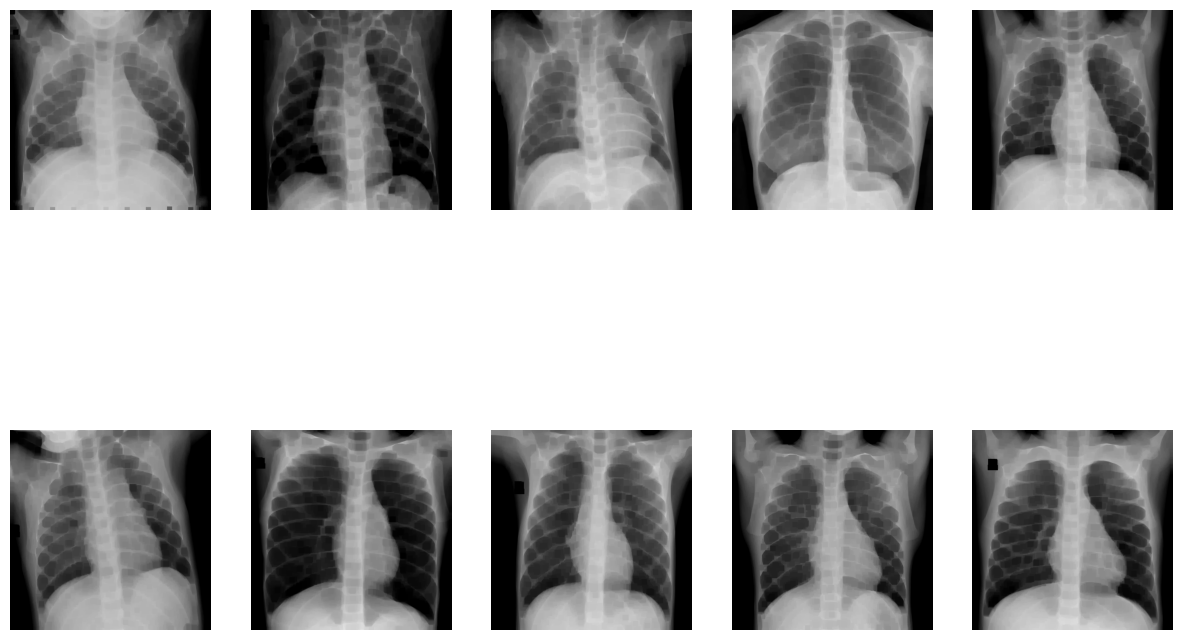

In [11]:
fig=plt.figure(figsize=(15, 10))
columns = 5; rows = 2
for i in range(1, columns*rows +1):
    img = cv2.imread(images[i])
    img = cv2.resize(img, (512, 512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    kernel = np.ones((5, 5), np.uint8)
    img_erosion = cv2.erode(img, kernel, iterations=3)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img_erosion)
    plt.axis(False)

## Image Dilation

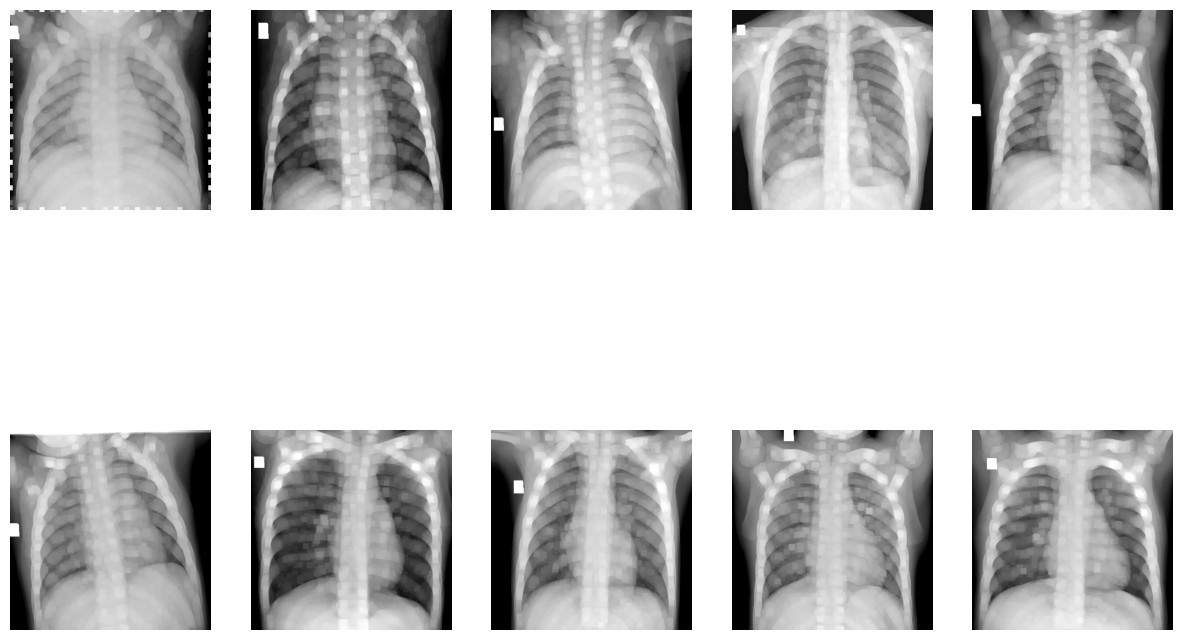

In [12]:
fig=plt.figure(figsize=(15, 10))
columns = 5; rows = 2
for i in range(1, columns*rows +1):
    img = cv2.imread(images[i])
    img = cv2.resize(img, (512, 512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    kernel = np.ones((5, 5), np.uint8)
    img_erosion = cv2.dilate(img, kernel, iterations=3)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img_erosion)
    plt.axis(False)

## Canny Edge Detection

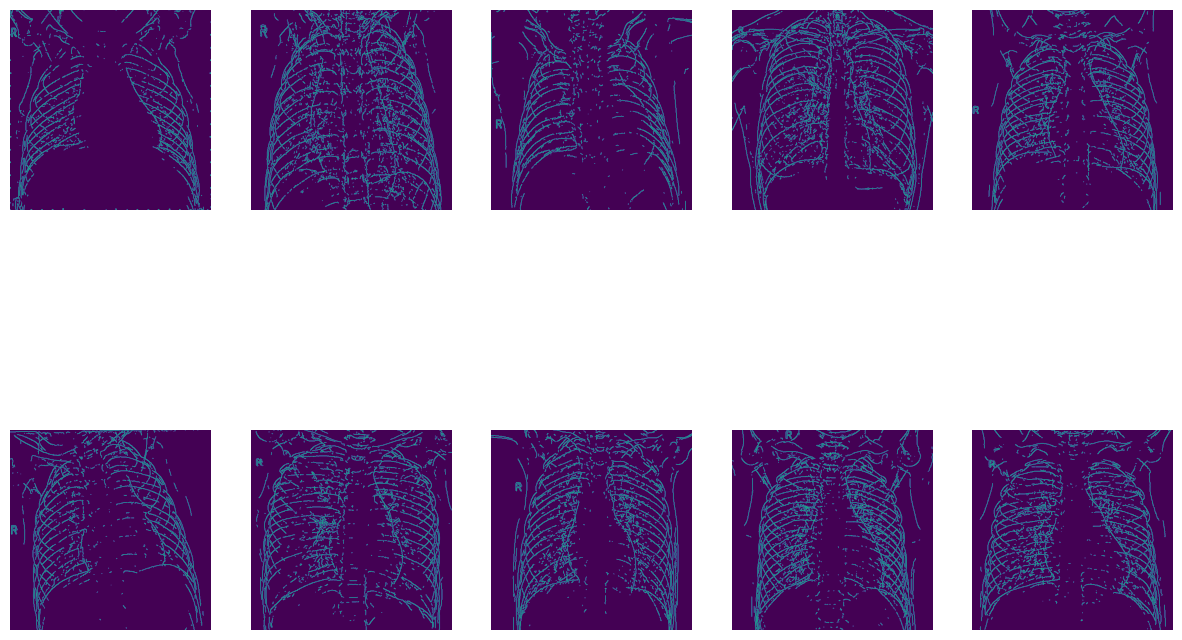

In [13]:
fig=plt.figure(figsize=(15, 10))
columns = 5; rows = 2
for i in range(1, columns*rows +1):
    img = cv2.imread(images[i])
    img = cv2.resize(img, (512, 512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(img, 80, 100)
    fig.add_subplot(rows, columns, i)
    plt.imshow(edges)
    plt.axis(False)

<div style="
  background-color: #e3f2fd;
  padding: 15px;
  border-left: 6px solid #0d47a1;
  border-radius: 8px;
  font-family: 'Georgia', serif;
  color: #01579b;
  font-size: 28px;
  text-align: center;
  font-weight: bold;
">
  📥 Reading the Data

</div>


In [6]:
train_images = load_images_from_folder(train_pneumonia_dir)
test_images = load_images_from_folder(test_pneumonia_dir)
valid_images = load_images_from_folder(valid_pneumonia_dir)

X = train_images + test_images + valid_images

X = np.array(X)

X = (X - 127.5) / 127.5

print(f"Loaded {len(X)} images, each resized to {target_size}.")

Loaded 4273 images, each resized to (128, 128).


In [7]:
X.shape

(4273, 128, 128, 3)

In [8]:
dataset = tf.data.Dataset.from_tensor_slices(X).shuffle(buffer_size=1000).batch(batch_size)

<div style="
  background-color: #e3f2fd;
  padding: 15px;
  border-left: 6px solid #0d47a1;
  border-radius: 8px;
  font-family: 'Georgia', serif;
  color: #01579b;
  font-size: 28px;
  text-align: center;
  font-weight: bold;
">
  🧠 Modeling

</div>


In [62]:
generator = tf.keras.Sequential()

# First layer: Dense + BatchNorm + LeakyReLU, input shape is the noise vector (100,)
generator.add(layers.Dense(16 * 16 * 256, use_bias=False, input_shape=(100,)))
generator.add(layers.BatchNormalization())
generator.add(layers.LeakyReLU())

# Reshape the output to (16, 16, 256)
generator.add(layers.Reshape((16, 16, 256)))

# Layer 2: Upsample to (32, 32, 128) with Conv2DTranspose
generator.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
generator.add(layers.BatchNormalization())
generator.add(layers.LeakyReLU())

# Layer 3: Upsample to (64, 64, 64) with Conv2DTranspose
generator.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
generator.add(layers.BatchNormalization())
generator.add(layers.LeakyReLU())

# Layer 4: Upsample to (128, 128, 32) with Conv2DTranspose
generator.add(layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False))
generator.add(layers.BatchNormalization())
generator.add(layers.LeakyReLU())

# Final output layer: Conv2DTranspose to get the 128x128x3 RGB image
generator.add(layers.Conv2DTranspose(3, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='tanh'))

# Model summary
generator.summary()


In [63]:
discriminator = tf.keras.Sequential()

# First layer: Input shape (128, 128, 3) -> Downsample to (64, 64, 64)
discriminator.add(layers.Conv2D(64, kernel_size=4, strides=2, padding='same', input_shape=(128, 128, 3), use_bias=False))
discriminator.add(layers.LeakyReLU(0.2))

# Second layer: Downsample to (32, 32, 128)
discriminator.add(layers.Conv2D(128, kernel_size=4, strides=2, padding='same', use_bias=False))
discriminator.add(layers.BatchNormalization())
discriminator.add(layers.LeakyReLU(0.2))

# Third layer: Downsample to (16, 16, 256)
discriminator.add(layers.Conv2D(256, kernel_size=4, strides=2, padding='same', use_bias=False))
discriminator.add(layers.BatchNormalization())
discriminator.add(layers.LeakyReLU(0.2))

# Fourth layer: Downsample to (8, 8, 512)
discriminator.add(layers.Conv2D(512, kernel_size=4, strides=2, padding='same', use_bias=False))
discriminator.add(layers.BatchNormalization())
discriminator.add(layers.LeakyReLU(0.2))

# Fifth layer: Downsample to (4, 4, 512) and then to a single value
discriminator.add(layers.Conv2D(1, kernel_size=4, strides=1, padding='valid', use_bias=False))
discriminator.add(layers.Flatten())  # Flatten to a single output
discriminator.add(layers.Activation('sigmoid'))  # Binary classification (real or fake)

# Model summary
discriminator.summary()


In [64]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(0.001)
discriminator_optimizer = tf.keras.optimizers.Adam(0.0002)

In [65]:
@tf.function
def train_step(images, batch_size):
    noise = tf.random.normal([batch_size, 100])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

In [66]:
def train(dataset, epochs, batch_size):
    """
    Trains the GAN model for a specified number of epochs.
    
    Parameters:
        dataset (tf.data.Dataset): The dataset containing real images, usually preprocessed and batched.
        epochs (int): Number of epochs to train the model.
        batch_size (int): The size of batches used during training.
    """
    g_losses,d_losses = [],[]
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch, batch_size)
            g_losses.append(gen_loss)
            d_losses.append(disc_loss)

        
        print(f"Generator Loss: {gen_loss}, Discriminator Loss: {disc_loss}")
        
        
        if (epoch + 1) % 50 == 0:  # Save model every 50 epochs
            generator.save(f'generator_epoch_{epoch+1}.h5')
            discriminator.save(f'discriminator_epoch_{epoch+1}.h5')
            
    return g_losses,d_losses

In [69]:
g_losses,d_losses = train(dataset, epochs=300, batch_size=batch_size)

Epoch 1/300

Generator Loss: 7.427107810974121, Discriminator Loss: 0.011192403733730316

Epoch 2/300

Generator Loss: 6.468603134155273, Discriminator Loss: 0.011352059431374073

Epoch 3/300

Generator Loss: 3.1184334754943848, Discriminator Loss: 0.1950475573539734

Epoch 4/300

Generator Loss: 2.150148391723633, Discriminator Loss: 0.581264853477478

Epoch 5/300

Generator Loss: 5.419488906860352, Discriminator Loss: 0.06099686399102211

Epoch 6/300

Generator Loss: 3.027984619140625, Discriminator Loss: 0.32603180408477783

Epoch 7/300

Generator Loss: 4.227447032928467, Discriminator Loss: 1.4978750944137573

Epoch 8/300

Generator Loss: 2.3296163082122803, Discriminator Loss: 0.36979782581329346

Epoch 9/300

Generator Loss: 3.332735776901245, Discriminator Loss: 0.23275476694107056

Epoch 10/300

Generator Loss: 4.400124549865723, Discriminator Loss: 0.08159135282039642

Epoch 11/300

Generator Loss: 5.821608543395996, Discriminator Loss: 0.07255689799785614

Epoch 12/300

Gener

In [71]:
noise = tf.random.normal([10, 100])

In [72]:
images = generator(noise, training=False)

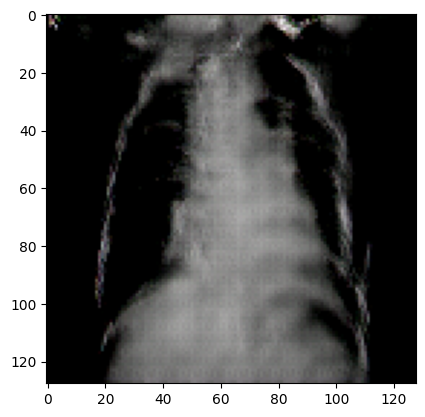

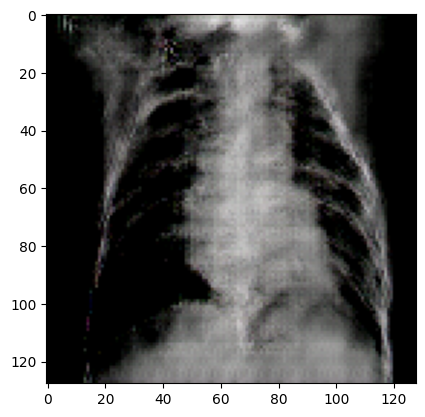

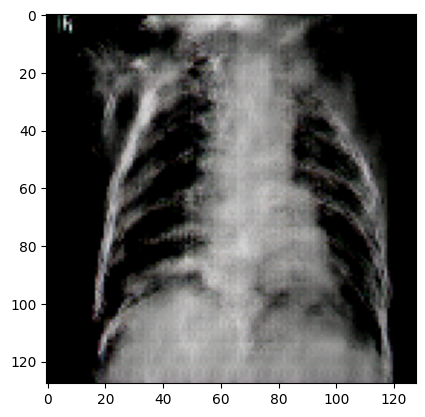

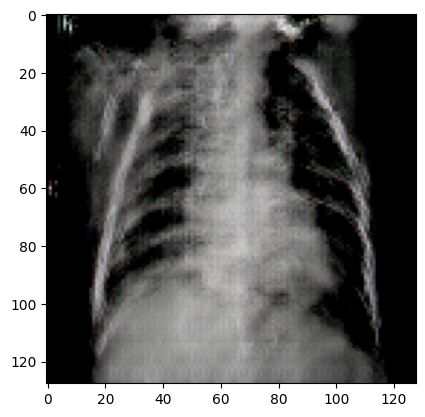

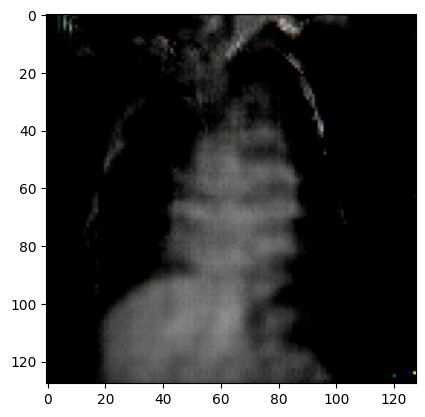

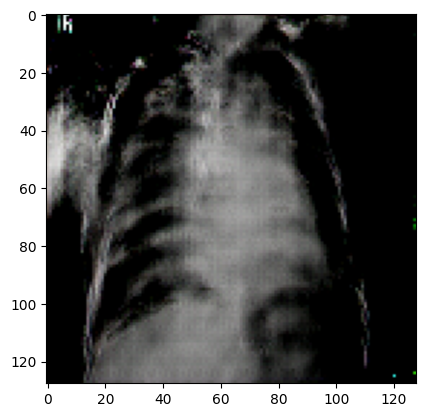

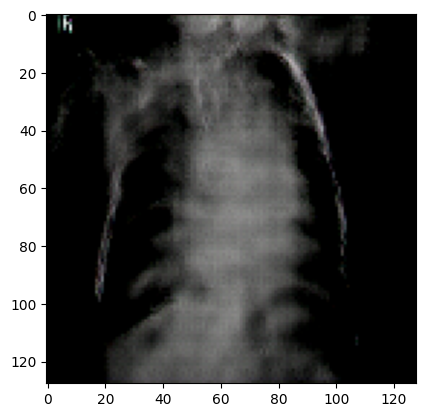

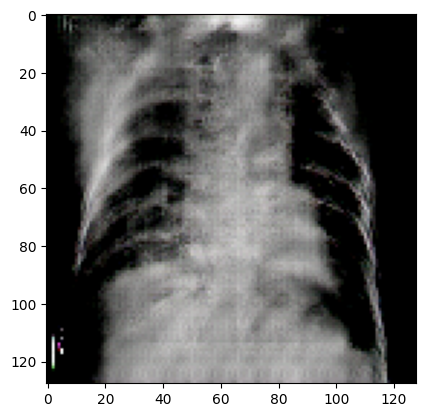

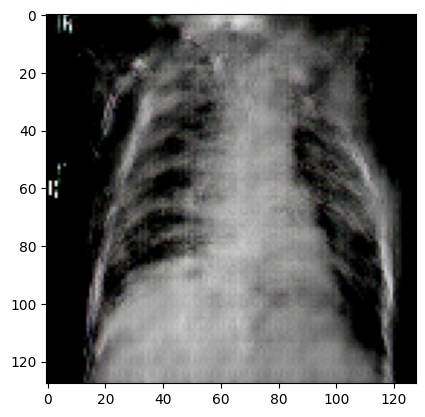

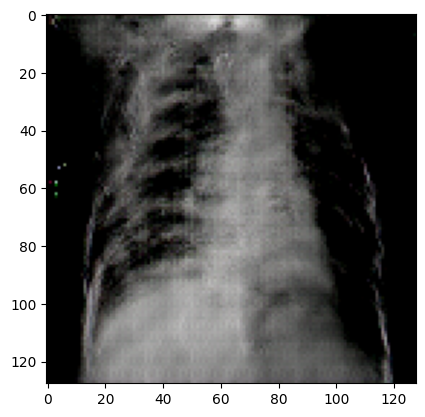

In [73]:
for image in images:
    plt.imshow(image.numpy().reshape(128,128, 3))
    plt.show()